In [2]:
import urllib
import os
import glob
import random
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D, Dropout
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

import utils

Using TensorFlow backend.


In [3]:
image_size = (512,512)
n_slices = 16
ratio = (1, 1)

## Load Training Images

In [25]:
CORPUS_PATH = "train"
TEST_PATH = "test"
OUTPUT_PATH = "output"

In [14]:
classes = os.listdir(CORPUS_PATH)

image_list = []
label_list = []

for label, c in enumerate(classes):
    print(c)
    terrain_path = os.path.join(CORPUS_PATH, c)
    for f_name in os.listdir(terrain_path):
        img = cv2.imread(os.path.join(terrain_path, f_name), 0)
        img_resize = cv2.resize(img, image_size)
        slices = utils.prepare_images(img_resize, image_size, ratio, n_slices)
        image_list.append(np.expand_dims(slices, -1))
        label_list.append(np.full((slices.shape[0]), label))
        
X_train = np.concatenate(image_list)
labels = np.concatenate(label_list)
one_hot_labels = to_categorical(labels, num_classes=len(classes))

vegetation
water
desert
clouds


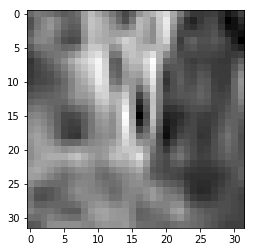

In [15]:
plt.imshow(X_train[50, :, :, 0], cmap='gray')

## Create Model

In [7]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_tensor = Input(input_shape, dtype=np.float32)

In [9]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

opt = optimizers.rmsprop(lr=0.001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Train Model

In [16]:
history = model.fit(X_train, one_hot_labels, epochs=300, batch_size=1024)

Epoch 1/300
15616/15616 [==============================] - 3s - loss: 1.1470 - acc: 0.5649     
Epoch 2/300
15616/15616 [==============================] - 3s - loss: 0.9943 - acc: 0.5847     
Epoch 3/300
15616/15616 [==============================] - 3s - loss: 0.9646 - acc: 0.5932     
Epoch 4/300
15616/15616 [==============================] - 3s - loss: 0.9476 - acc: 0.6070     
Epoch 5/300
15616/15616 [==============================] - 3s - loss: 0.9532 - acc: 0.6027     
Epoch 6/300
15616/15616 [==============================] - 3s - loss: 1.0230 - acc: 0.5715     
Epoch 7/300
15616/15616 [==============================] - 3s - loss: 0.9217 - acc: 0.6147     
Epoch 8/300
15616/15616 [==============================] - 3s - loss: 0.8869 - acc: 0.6302     
Epoch 9/300
15616/15616 [==============================] - 3s - loss: 0.8763 - acc: 0.6300     
Epoch 10/300
15616/15616 [==============================] - 3s - loss: 0.9279 - acc: 0.6081     
Epoch 11/300
15616/15616 [=============

KeyboardInterrupt: 

## Read test images

In [147]:
def download_image(url, file_name):
    return urllib.urlretrieve(url, file_name)

In [148]:
with open("test_images.txt", 'r') as f:
    image_urls = f.read().split("\n")

In [149]:
for i, image_url in enumerate(image_urls):
    download_image(image_url, os.path.join(TEST_PATH, str(i)))

In [28]:
image_list = []
gray_list = []
for f_name in os.listdir(TEST_PATH):
    img = cv2.imread(os.path.join(TEST_PATH, f_name))
    img_resize = cv2.resize(img, image_size)
    img_gray = gray_image = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
    slices = utils.prepare_images(img_gray, image_size, ratio, n_slices)
    gray_list.append(np.expand_dims(slices, -1))
    image_list.append(img_resize)
    
images = np.stack(image_list)
X = np.stack(gray_list)
X = X.reshape(X.shape[0] * X.shape[1], X.shape[2], X.shape[3], X.shape[4])

## Predict Labels

vegetation

water

desert

clouds

In [29]:
preds = model.predict(X)

In [30]:
labels = np.argmax(preds, axis=1)

In [31]:
labels = np.reshape(labels, (len(images), n_slices, n_slices))

## Visualize Predictions

In [32]:
colors = [(124,252,0), (0,191,255), (244,164,96), (255, 255, 255)]

In [33]:
for i, (img, l) in enumerate(zip(images, labels)):
    assignment_mask = np.zeros((l.shape[0], l.shape[1], 3))
    
    for label in xrange(len(classes)):
        assignment_mask[np.isin(l, label)] = colors[label]
        
    alpha = 0.5
    output = img.copy()
    output = output.astype('uint8')
    assignment_mask = assignment_mask.astype('uint8')
    assignment_mask = cv2.resize(assignment_mask, image_size, interpolation=cv2.INTER_CUBIC)
    overlay = assignment_mask
    output = cv2.addWeighted(overlay, alpha, output, 1 - alpha,
                    0, output)
    cv2.imwrite(os.path.join(OUTPUT_PATH, "{}.jpg".format(i)), output)

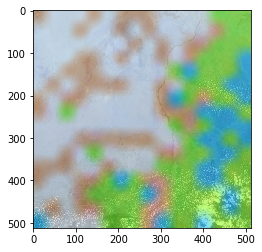

In [34]:
plt.imshow(output)